In [1]:
# importing libaries
!pip install -U accelerate
!pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 5.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
gptData = pd.read_csv('/content/drive/MyDrive/datasets/reddit/TrainingTwitterData.csv') # change file path for local file system.

In [5]:
count_negative = sum(label == 2 for label in gptData['labels'])
count_negative # count of negatives

107796

In [6]:
import re

In [7]:
gptData.head()

,tweets,labels
0,chatgpt optimizing language models for dialogu...,0
1,try talking with chatgpt our new ai system whi...,1
2,chatgpt optimizing language models for dialogu...,0
3,thrilled to share that chatgpt our new model o...,1
4,as of 2 minutes ago openai released their new ...,2


In [8]:
gptDataUnlabeled = pd.read_csv('/content/drive/MyDrive/datasets/reddit/testRedditData.csv')

In [9]:
gptDataUnlabeled.head()

,Id,Comment
0,29044,this is perfect because ive used chatgpt to wr...
1,12965,i wouldnt always trust what chatgpt says about...
2,2320,i heard in an interview that the cost per chat...
3,28435,i had it write some rudimentary functions in c...
4,6739,chatgpt is so impressive though. i am using it...


In [10]:
# balancing the sentiment distribution in the dataset
positive_data = gptData[gptData['labels'] == 1].head(15000)
negative_data = gptData[gptData['labels'] == 2].head(15000)
neutral_data = gptData[gptData['labels'] == 0].head(15000)
merged_data = pd.concat([positive_data, negative_data, neutral_data], ignore_index=True)

In [13]:
gptData = merged_data # overwriting the gptData

In [14]:
len(gptData)

45000

In [15]:
len(merged_data)

45000

In [16]:
from transformers import BertTokenizer, BertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
model = model.to('cuda') # utilizes CUDA.

In [18]:
# check for missing values
print(gptData.isnull().sum())

tweets    0
labels    0
dtype: int64


In [19]:
# Remove missing values
gptData = gptData.dropna()
print("Length: ",len(gptData))

Length:  45000


In [20]:
print(gptData.isnull().sum())

tweets    0
labels    0
dtype: int64


In [23]:
gptData.head()

,tweets,labels
0,try talking with chatgpt our new ai system whi...,1
1,thrilled to share that chatgpt our new model o...,1
2,just launched chatgpt our new ai system which ...,1
3,chatgpt coming out strong refusing to help me ...,1
4,0penal just deployed a thing ive been helping ...,1


In [25]:
# converting to a list
X = list(gptData['tweets'])
y = list(gptData['labels'])

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, train_size=0.8) # training and testing dataset splitted into 80% 20%

In [28]:
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512) # tokenized training data
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512) # tokenized validation data

In [29]:
X_train_tokenized.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [30]:
print(X_train_tokenized['input_ids'][0])

[101, 2652, 2007, 11834, 21600, 2102, 1998, 2018, 2000, 3198, 2009, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [31]:
len(X_train), len(X_val)

(36000, 9000)

In [32]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings["input_ids"])

In [33]:
train_dataset = Dataset(X_train_tokenized, y_train) # converting into a compatible format
val_dataset = Dataset(X_val_tokenized, y_val) # converting into a compatible format

In [34]:
train_dataset[5]

{'input_ids': tensor([  101, 11834, 21600,  2102,  2097,  6570,  2017,  6997,  2065,  2017,
          3198,  2009,  2000,  4863,  1999,  4623,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [45]:
model_name = "bert-finetuned-chatGPT"

# Training arguments.
training_args = TrainingArguments(
  output_dir=model_name, # Directory for saving outputs
  learning_rate=3.7988668524141836e-05, # Learning rate for optimization
  seed = 3, # num of random seeds
  per_device_train_batch_size=16, # Batch size for training
  per_device_eval_batch_size=16, # Batch size for evaluation
  num_train_epochs=3, # Number of training epochs
  weight_decay=0.01, # Weight decay for regularization
  evaluation_strategy="epoch", # Evaluation is done at the end of each epoch
  save_strategy = "epoch",
  warmup_steps=500,
)

In [46]:
def model_init():
  return BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

In [47]:
# Trainer Initialization using training pipeline from huggingface.
trainer = Trainer(
  model_init=model_init,
  args=training_args,
  train_dataset=train_dataset,
  eval_dataset=val_dataset,
  compute_metrics=lambda p: {"accuracy": accuracy_score(p.label_ids,
  np.argmax(p.predictions, axis=1))},
  tokenizer=tokenizer
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
! pip install optuna
! pip install ray[tune]

# Hyper parameter search for 10 number of trials to find the maximized accuracy
eval = trainer.hyperparameter_search(n_trials=10, direction="maximize")
print(eval)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 13.4 MB/s eta 0:00:00


[I 2024-04-25 12:39:11,691] A new study created in memory with name: no-name-ca409ac8-eb39-4609-97af-2b05f07228df
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.728500,0.743840,0.686667
2,0.619000,0.616324,0.766222
3,0.596300,0.627711,0.794667
4,0.581000,0.645228,0.797889


[I 2024-04-25 13:43:43,204] Trial 0 finished with value: 0.7978888888888889 and parameters: {'learning_rate': 1.090478162982425e-06, 'num_train_epochs': 4, 'seed': 3, 'per_device_train_batch_size': 4}. Best is trial 0 with value: 0.7978888888888889.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.430300,0.484197,0.849333
2,0.325000,0.439848,0.889333
3,0.240000,0.476831,0.894222
4,0.192600,0.530178,0.895222


[I 2024-04-25 14:35:27,408] Trial 1 finished with value: 0.8952222222222223 and parameters: {'learning_rate': 1.7619414294877337e-05, 'num_train_epochs': 4, 'seed': 36, 'per_device_train_batch_size': 8}. Best is trial 1 with value: 0.8952222222222223.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.850200,0.511579,0.800667


[I 2024-04-25 14:45:26,865] Trial 2 finished with value: 0.8006666666666666 and parameters: {'learning_rate': 1.9291695717112818e-05, 'num_train_epochs': 1, 'seed': 12, 'per_device_train_batch_size': 64}. Best is trial 1 with value: 0.8952222222222223.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.563800,0.541134,0.864222
2,0.421000,0.576749,0.876889


[I 2024-04-25 15:17:39,153] Trial 3 finished with value: 0.8768888888888889 and parameters: {'learning_rate': 1.1806923704630815e-05, 'num_train_epochs': 2, 'seed': 14, 'per_device_train_batch_size': 4}. Best is trial 1 with value: 0.8952222222222223.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.409500,0.393843,0.866889
2,0.279600,0.335868,0.888778
3,0.189100,0.377075,0.900111


[I 2024-04-25 15:51:21,529] Trial 4 finished with value: 0.9001111111111111 and parameters: {'learning_rate': 3.7988668524141836e-05, 'num_train_epochs': 3, 'seed': 3, 'per_device_train_batch_size': 16}. Best is trial 4 with value: 0.9001111111111111.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.705300,0.693888,0.706778


[I 2024-04-25 16:07:38,764] Trial 5 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.866600,0.758294,0.664444


Epoch,Training Loss,Validation Loss,Accuracy
1,0.866600,0.758294,0.664444
2,0.697100,0.672406,0.713000


[I 2024-04-25 16:28:41,777] Trial 6 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.754000,0.419415,0.843222
2,0.363800,0.348105,0.881889
3,0.231200,0.331498,0.893444


[I 2024-04-25 16:58:43,518] Trial 7 finished with value: 0.8934444444444445 and parameters: {'learning_rate': 4.451602079966553e-05, 'num_train_epochs': 3, 'seed': 18, 'per_device_train_batch_size': 64}. Best is trial 4 with value: 0.9001111111111111.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.463100,0.446097,0.844000


[I 2024-04-25 17:11:43,866] Trial 8 pruned. 
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.042500,0.847837,0.612778


[I 2024-04-25 17:21:43,478] Trial 9 pruned. 


BestRun(run_id='4', objective=0.9001111111111111, hyperparameters={'learning_rate': 3.7988668524141836e-05, 'num_train_epochs': 3, 'seed': 3, 'per_device_train_batch_size': 16}, run_summary=None)


In [48]:
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.409500,0.393843,0.866889
2,0.279600,0.335868,0.888778
3,0.189100,0.377075,0.900111


TrainOutput(global_step=6750, training_loss=0.35338110125506367, metrics={'train_runtime': 2027.7559, 'train_samples_per_second': 53.261, 'train_steps_per_second': 3.329, 'total_flos': 5272546222440000.0, 'train_loss': 0.35338110125506367, 'epoch': 3.0})

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluating the model on the validation set
predictions = trainer.predict(val_dataset)

# Extracting predicted labels
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Calculating confusion matrix
conf_matrix = confusion_matrix(y_val, predicted_labels)



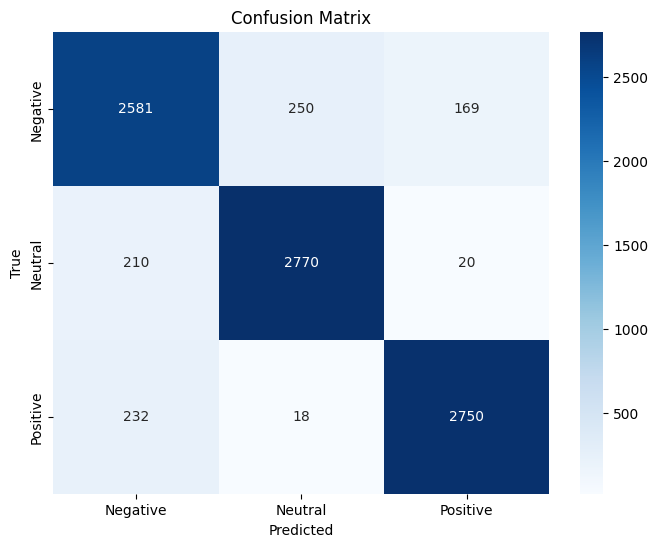

In [50]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [51]:
from huggingface_hub import notebook_login
notebook_login()

In [52]:
!apt install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [54]:
trainer.push_to_hub()

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/876M [00:00<?, ?B/s]

Upload 51 LFS files:   0%|          | 0/51 [00:00<?, ?it/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/876M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.98k [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/876M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/876M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/876M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.98k [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/876M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/876M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.98k [00:00<?, ?B/s]

events.out.tfevents.1714044424.65813c9608ff.717.0:   0%|          | 0.00/7.44k [00:00<?, ?B/s]

events.out.tfevents.1714046686.65813c9608ff.717.1:   0%|          | 0.00/7.44k [00:00<?, ?B/s]

events.out.tfevents.1714048752.65813c9608ff.717.2:   0%|          | 0.00/21.9k [00:00<?, ?B/s]

events.out.tfevents.1714052624.65813c9608ff.717.3:   0%|          | 0.00/14.1k [00:00<?, ?B/s]

events.out.tfevents.1714055728.65813c9608ff.717.4:   0%|          | 0.00/5.74k [00:00<?, ?B/s]

events.out.tfevents.1714056327.65813c9608ff.717.5:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

events.out.tfevents.1714058260.65813c9608ff.717.6:   0%|          | 0.00/8.92k [00:00<?, ?B/s]

events.out.tfevents.1714060282.65813c9608ff.717.7:   0%|          | 0.00/8.97k [00:00<?, ?B/s]

events.out.tfevents.1714061259.65813c9608ff.717.8:   0%|          | 0.00/6.34k [00:00<?, ?B/s]

events.out.tfevents.1714062522.65813c9608ff.717.9:   0%|          | 0.00/6.81k [00:00<?, ?B/s]

events.out.tfevents.1714064324.65813c9608ff.717.10:   0%|          | 0.00/7.08k [00:00<?, ?B/s]

events.out.tfevents.1714065104.65813c9608ff.717.11:   0%|          | 0.00/5.39k [00:00<?, ?B/s]

events.out.tfevents.1714065863.65813c9608ff.717.12:   0%|          | 0.00/11.8k [00:00<?, ?B/s]

events.out.tfevents.1714068371.65813c9608ff.717.13:   0%|          | 0.00/8.92k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.98k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/iaminhridoy/chatGPTPrevious/commit/c20d7dff3bc54fa68b163fb54fc35bfe02ac208f', commit_message='End of training', commit_description='', oid='c20d7dff3bc54fa68b163fb54fc35bfe02ac208f', pr_url=None, pr_revision=None, pr_num=None)

In [55]:
# check for missing values
print(gptDataUnlabeled.isnull().sum())

Id          0
Comment    15
dtype: int64


In [56]:
print("Length: ",len(gptDataUnlabeled))

Length:  7000


In [57]:
# Removing missing values from the dataset.
gptDataUnlabeled = gptDataUnlabeled.dropna()
print("Length: ",len(gptDataUnlabeled))

Length:  6985


In [58]:
X_unlabeled = list(gptDataUnlabeled['Comment'])
X_unlabeled_tokenized = tokenizer(X_unlabeled, padding=True, truncation=True, max_length=512) # tokenized Reddit data

In [59]:
class UnlabeledDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [60]:
unlabeled_dataset = UnlabeledDataset(X_unlabeled_tokenized)

In [61]:
predictions = trainer.predict(unlabeled_dataset) # predictions on Reddit dataset.

In [62]:
predicted_labels = np.argmax(predictions.predictions, axis=1)

In [63]:
gptDataUnlabeled['predicted_labels'] = predicted_labels

In [64]:
gptDataUnlabeled.head()

,Id,Comment,predicted_labels
0,29044,this is perfect because ive used chatgpt to wr...,1
1,12965,i wouldnt always trust what chatgpt says about...,1
2,2320,i heard in an interview that the cost per chat...,2
3,28435,i had it write some rudimentary functions in c...,1
4,6739,chatgpt is so impressive though. i am using it...,1


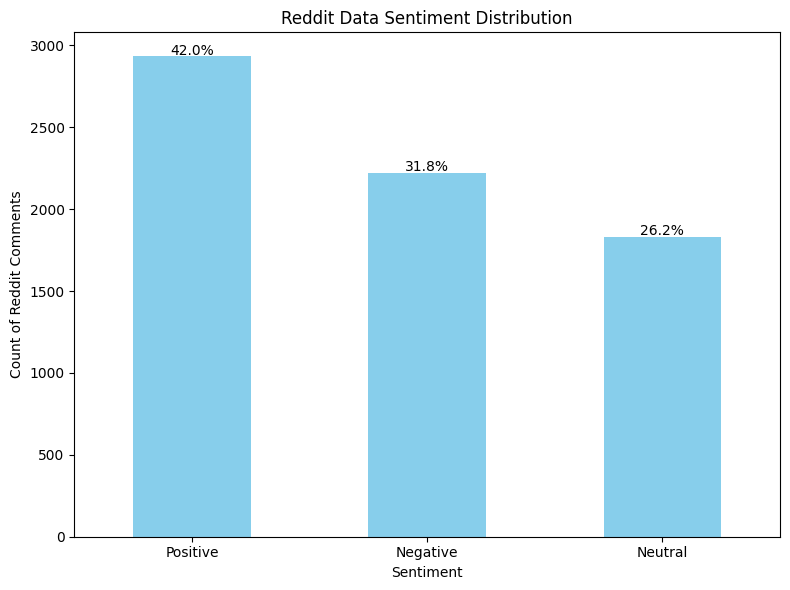

In [65]:
import matplotlib.pyplot as plt

sentiment_counts = gptDataUnlabeled['predicted_labels'].value_counts() # sentiment counts

label_mapping = {1: 'Positive', 2: 'Negative', 0: 'Neutral'}

# Replacing labels in sentiment_counts using the label_mapping dictionary
sentiment_counts = sentiment_counts.rename(index=label_mapping)

total_tweets = sentiment_counts.sum()
percentage = (sentiment_counts / total_tweets) * 100

# Plotting the bar chart
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color='skyblue')
plt.title('Reddit Data Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count of Reddit Comments')
plt.xticks(rotation=0)

# Adding percentages to the bars
for i, count in enumerate(sentiment_counts):
    plt.text(i, count + 10, f'{percentage[i]:.1f}%', ha='center')

plt.tight_layout()
plt.show()

In [66]:
gptDataUnlabeled.to_csv('gptDataPredictedLabel.csv')

In [67]:
gpt = pd.read_csv('/content/drive/MyDrive/datasets/chatGPT_Vader_n_Blob_Sentiment.csv')

In [68]:
gpt.head()

,Processed_Tweets,Vader_Polarity,Blob_Polarity
0,openais gpt4 just got supercharged ai chatgpt,0.0000,0.0
1,classical art is struggling not changed the fa...,-0.2500,0.2
2,alibaba invites businesses to trial chatgpt ri...,0.0000,0.0
3,trying to stop students from using ai and chat...,-0.2263,0.1
4,i asked chatgpts ai chatbot how can i earn cry...,0.0000,0.0


In [69]:
X_gpt = list(gpt['Processed_Tweets'])
X_gpt_tokenized = tokenizer(X_gpt, padding=True, truncation=True, max_length=512)

In [70]:
class GPTDataset(torch.utils.data.Dataset): # custom data class to convert into Py-torch's compatible format.
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [71]:
gpt_dataset = GPTDataset(X_gpt_tokenized)

In [72]:
predictions = trainer.predict(gpt_dataset) # using trainer to predict the data

In [73]:
predicted_gpt_labels = np.argmax(predictions.predictions, axis=1)

In [74]:
gpt.head()

,Processed_Tweets,Vader_Polarity,Blob_Polarity
0,openais gpt4 just got supercharged ai chatgpt,0.0000,0.0
1,classical art is struggling not changed the fa...,-0.2500,0.2
2,alibaba invites businesses to trial chatgpt ri...,0.0000,0.0
3,trying to stop students from using ai and chat...,-0.2263,0.1
4,i asked chatgpts ai chatbot how can i earn cry...,0.0000,0.0


In [75]:
gpt['predicted_label'] = predicted_gpt_labels

In [76]:
gpt.head(1000)

,Processed_Tweets,Vader_Polarity,Blob_Polarity,predicted_label
0,openais gpt4 just got supercharged ai chatgpt,0.0000,0.000000,2
1,classical art is struggling not changed the fa...,-0.2500,0.200000,2
2,alibaba invites businesses to trial chatgpt ri...,0.0000,0.000000,2
3,trying to stop students from using ai and chat...,-0.2263,0.100000,2
4,i asked chatgpts ai chatbot how can i earn cry...,0.0000,0.000000,0
...,...,...,...,...
995,rasbt memdotai mem it chatgpt,0.0000,0.000000,2
996,an australian mayor may sue openai after chatg...,-0.5411,-0.166667,2
997,oh now its friday released a new version of po...,0.0382,0.068182,2
998,using company data to search in chatgpt is dat...,-0.3400,0.000000,2


In [77]:
gpt.to_csv('TwittergptDataPredictedLabel.csv')

In [81]:
gpt.to_csv('/content/drive/MyDrive/datasets/gptDataBertPredictedLabel.csv')

In [78]:
gpt.head()

,Processed_Tweets,Vader_Polarity,Blob_Polarity,predicted_label
0,openais gpt4 just got supercharged ai chatgpt,0.0000,0.0,2
1,classical art is struggling not changed the fa...,-0.2500,0.2,2
2,alibaba invites businesses to trial chatgpt ri...,0.0000,0.0,2
3,trying to stop students from using ai and chat...,-0.2263,0.1,2
4,i asked chatgpts ai chatbot how can i earn cry...,0.0000,0.0,0


In [79]:
len(gpt)

362566

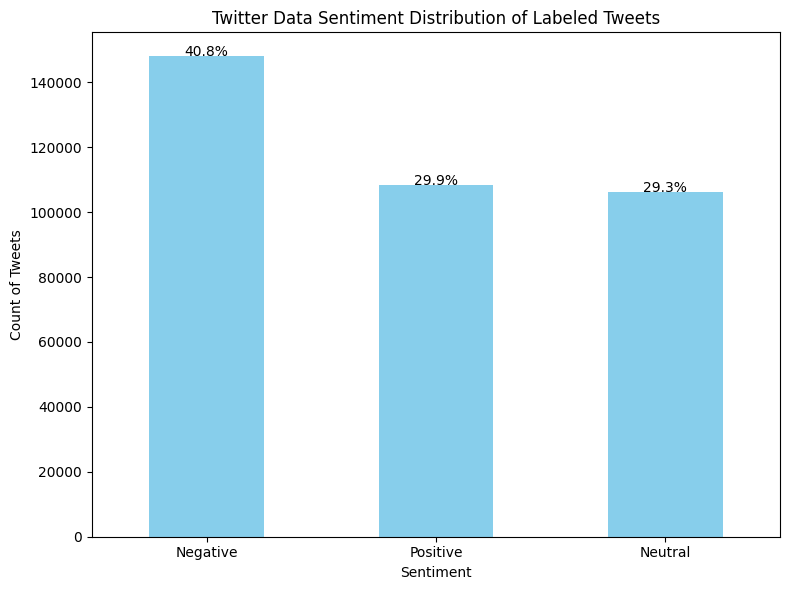

In [80]:
import matplotlib.pyplot as plt

sentiment_counts = gpt['predicted_label'].value_counts()

label_mapping = {1: 'Positive', 2: 'Negative', 0: 'Neutral'}

# Replacing labels in sentiment_counts using the label_mapping dictionary
sentiment_counts = sentiment_counts.rename(index=label_mapping)

total_tweets = sentiment_counts.sum()
percentage = (sentiment_counts / total_tweets) * 100

# Plotting the bar chart
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color='skyblue')
plt.title('Twitter Data Sentiment Distribution of Labeled Tweets')
plt.xlabel('Sentiment')
plt.ylabel('Count of Tweets')
plt.xticks(rotation=0)

# Adding percentages to the bars
for i, count in enumerate(sentiment_counts):
    plt.text(i, count + 10, f'{percentage[i]:.1f}%', ha='center')

plt.tight_layout()
plt.show()